<a href="https://colab.research.google.com/github/SydAt1/Emotion_Detection_AML/blob/main/retraining_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model for Grouped Emotion Classification


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (classification_report, hamming_loss, accuracy_score,
                            precision_recall_fscore_support, multilabel_confusion_matrix,
                            roc_curve, auc, precision_recall_curve)
from sklearn.model_selection import train_test_split
from itertools import product
import joblib
import os

In [3]:
# Set paths
base_path = '/content/drive/MyDrive/Text_Emotion_Classifier'
dataset_path = os.path.join(base_path, 'dataset/new_emotions_dataset.csv')
splits_path = os.path.join(base_path, 'model/train-test-val')
save_dir = os.path.join(base_path, 'model/grouped_emotions_lstm')
os.makedirs(save_dir, exist_ok=True)

In [4]:
# Configuration
MAX_WORDS = 20000
MAX_LEN = 128
EPOCHS = 20
BATCH_SIZE = 256

In [5]:
# Load the new grouped emotions dataset
df = pd.read_csv(dataset_path)

# Define emotion columns (4 grouped emotions)
emotion_columns = ['positive', 'negative', 'uncertain', 'neutral']

In [6]:
# Check emotion distribution
emotion_counts = df[emotion_columns].sum().sort_values(ascending=False)
print("\nEmotion Distribution:")
for col in emotion_columns:
    count = df[col].sum()
    percentage = (count / len(df)) * 100
    print(f"  {col}: {count:,} ({percentage:.2f}%)")


Emotion Distribution:
  positive: 82,938 (39.91%)
  negative: 54,798 (26.37%)
  uncertain: 29,282 (14.09%)
  neutral: 55,298 (26.61%)


In [ ]:
df.head()


,text,example_very_unclear,neutral,cleaned_text,positive,negative,uncertain
0,That game hurt.,False,0,game hurt,0,1,0
1,"You do right, if you don't care then fuck 'em!",False,1,right not care fuck em,0,0,0
2,Man I love reddit.,False,0,man love reddit,1,0,0
3,"[NAME] was nowhere near them, he was by the Fa...",False,1,near falcon,0,0,0
4,Right? Considering it’s such an important docu...,False,0,right consider important document know damned ...,1,0,0


## Train Test Val Split


In [7]:
# Extract texts and labels
texts = df['cleaned_text'].astype(str).tolist()
labels = df[emotion_columns].values.astype('float32')

print(f"\nTotal samples: {len(texts)}")
print(f"Label shape: {labels.shape}")


Total samples: 207814
Label shape: (207814, 4)


In [9]:
# Split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    texts,
    labels,
    test_size=0.15,
    random_state=42,
    stratify=labels.argmax(axis=1)
)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,               # 15% of total
    random_state=42,
    stratify=y_temp.argmax(axis=1)
)

In [11]:
print(f"\nData split sizes:")
print(f"Train: {len(X_train)} ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Val: {len(X_val)} ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(texts)*100:.1f}%)")

print(f"\nLabel shapes:")
print(f"y_train: {y_train.shape}")
print(f"y_val: {y_val.shape}")
print(f"y_test: {y_test.shape}")


Data split sizes:
Train: 145463 (70.0%)
Val: 31178 (15.0%)
Test: 31173 (15.0%)

Label shapes:
y_train: (145463, 4)
y_val: (31178, 4)
y_test: (31173, 4)


## Tokenization and Sequence Preparation

In [ ]:
# Create and fit tokenizer on training data
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Using top {MAX_WORDS} words")

Vocabulary size: 25565
Using top 20000 words


In [15]:
# Convert texts to sequences
print("Converting texts to sequences...")
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

Converting texts to sequences...


In [16]:
# Pad sequences
X_train_pad = pad_sequences(sequences_train, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(sequences_val, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences_test, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nPadded sequence shapes:")
print(f"X_train: {X_train_pad.shape}")
print(f"X_val: {X_val_pad.shape}")
print(f"X_test: {X_test_pad.shape}")


Padded sequence shapes:
X_train: (145463, 128)
X_val: (31178, 128)
X_test: (31173, 128)


In [ ]:
# Save tokenizer for later use
tokenizer_path = os.path.join(save_dir, "tokenizer.pkl")
joblib.dump(tokenizer, tokenizer_path)
print(f"\nTokenizer saved to: {tokenizer_path}")


Tokenizer saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/tokenizer.pkl


## Build LSTM Model

In [ ]:
num_emotions = len(emotion_columns)

def build_lstm_model(emb_dim=128, units=128, dropout_rate=0.3, bidirectional=True):
    """Build LSTM model with specified hyperparameters"""
    model = Sequential()

    model.add(Embedding(input_dim=MAX_WORDS,
                       output_dim=emb_dim,
                       input_length=MAX_LEN))

    if bidirectional:
        model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    else:
        model.add(LSTM(units=units, return_sequences=False))

    model.add(Dropout(dropout_rate))
    model.add(Dense(num_emotions, activation='sigmoid'))

    return model

In [ ]:
# Build initial model with best hyperparameters
model = build_lstm_model(emb_dim=128, units=128, dropout_rate=0.3, bidirectional=True)

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Train Model with Early Stopping

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    os.path.join(save_dir, 'best_model_checkpoint.keras'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train the model
print("\nStarting training...")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Starting training...
Epoch 1/20
691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4726 - loss: 0.5205
Epoch 1: val_loss improved from inf to 0.44487, saving model to /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/best_model_checkpoint.keras
691/691 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4727 - loss: 0.5205 - val_accuracy: 0.5876 - val_loss: 0.4449
Epoch 2/20
689/691 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5960 - loss: 0.4410
Epoch 2: val_loss improved from 0.44487 to 0.41684, saving model to /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/best_model_checkpoint.keras
691/691 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.5960 - loss: 0.4410 - val_accuracy: 0.6190 - val_loss: 0.4168
Epoch 3/20
690/691 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6179 - loss: 0.4193
Epoch 3: val_loss improved from 0.41684 to 0.40620, saving model to /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lst

In [ ]:
# Save the final model
final_model_path = os.path.join(save_dir, "lstm_emotion_model.keras")
model.save(final_model_path)
print(f"\nFinal model saved to: {final_model_path}")


Final model saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/lstm_emotion_model.keras


## Visualize Training History

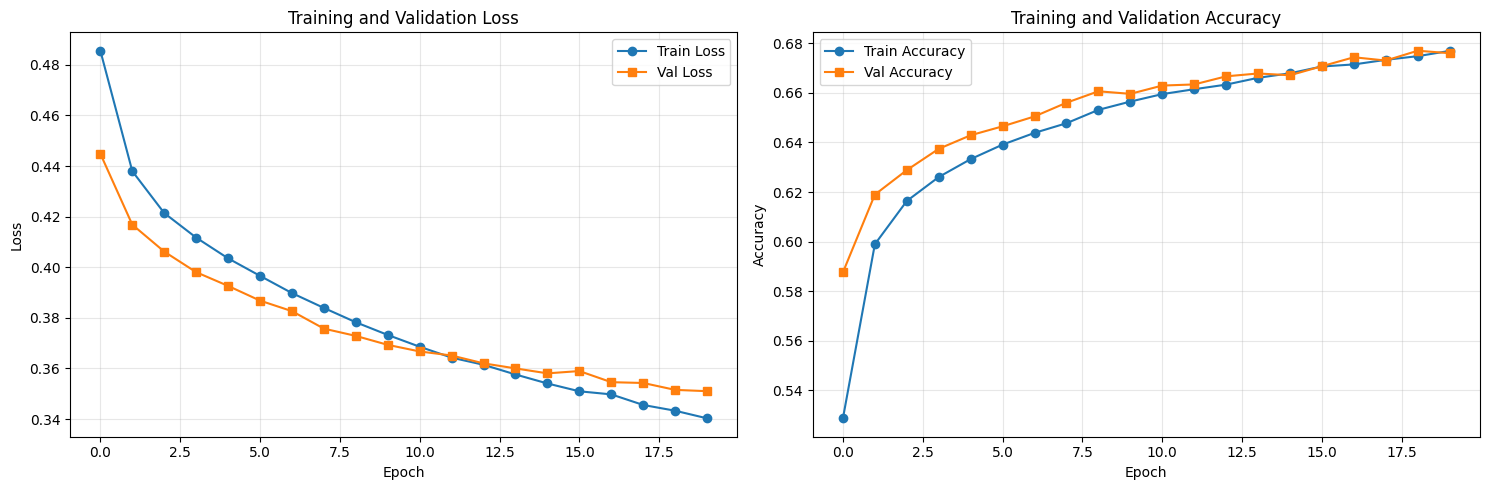

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(save_dir, 'training_history.csv'), index=False)
print(f"Training history saved to: {os.path.join(save_dir, 'training_history.csv')}")

Training history saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/training_history.csv


## Find Optimal Threshold on Validation Set

In [ ]:
# Get predictions on validation set
y_val_probs = model.predict(X_val_pad, verbose=0)

# Test different thresholds
best_thresh = 0.5
best_f1 = 0

for thresh in np.arange(0.2, 0.7, 0.01):
    y_pred_temp = (y_val_probs > thresh).astype(int)
    f1 = classification_report(y_val, y_pred_temp, output_dict=True, zero_division=0)['micro avg']['f1-score']
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f}")
print(f"Best Micro F1 on validation: {best_f1:.4f}")

# Save threshold
threshold_info = {'best_threshold': best_thresh, 'best_val_f1': best_f1}
pd.DataFrame([threshold_info]).to_csv(os.path.join(save_dir, 'best_threshold.csv'), index=False)

Best threshold: 0.35
Best Micro F1 on validation: 0.6922


## Evaluate on Test Set

In [ ]:
print("EVALUATING ON TEST SET")

# Predict on test set
y_test_probs = model.predict(X_test_pad, verbose=0)
y_test_pred = (y_test_probs > best_thresh).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
hamming = hamming_loss(y_test, y_test_pred)
precision, recall, f1_micro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='micro', zero_division=0
)
_, _, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average='macro', zero_division=0
)

print(f"\nTest Set Results (threshold = {best_thresh:.2f}):")
print(f"Exact Match Accuracy: {test_accuracy:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Micro-averaged F1: {f1_micro:.4f}")
print(f"Macro-averaged F1: {f1_macro:.4f}")

EVALUATING ON TEST SET

Test Set Results (threshold = 0.35):
Exact Match Accuracy: 0.4568
Hamming Loss: 0.2271
Micro-averaged F1: 0.6073
Macro-averaged F1: 0.5629


In [ ]:
# Per-emotion classification report
print("\nPer-Emotion Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=emotion_columns, zero_division=0))


Per-Emotion Classification Report:
              precision    recall  f1-score   support

    positive       0.68      0.79      0.73     12554
    negative       0.57      0.68      0.62      8290
   uncertain       0.41      0.37      0.39      4359
     neutral       0.46      0.58      0.51      8166

   micro avg       0.57      0.66      0.61     33369
   macro avg       0.53      0.60      0.56     33369
weighted avg       0.56      0.66      0.60     33369
 samples avg       0.59      0.66      0.61     33369



In [ ]:
# Save metrics
metrics_summary = {
    'best_threshold': best_thresh,
    'test_accuracy': test_accuracy,
    'hamming_loss': hamming,
    'f1_micro': f1_micro,
    'f1_macro': f1_macro,
    'precision_micro': precision,
    'recall_micro': recall
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv(os.path.join(save_dir, 'test_metrics.csv'), index=False)
print(f"\nMetrics saved to: {os.path.join(save_dir, 'test_metrics.csv')}")


Metrics saved to: /content/drive/MyDrive/Text_Emotion_Classifier/model/grouped_emotions_lstm/test_metrics.csv


## Confusion Matrix Visualization

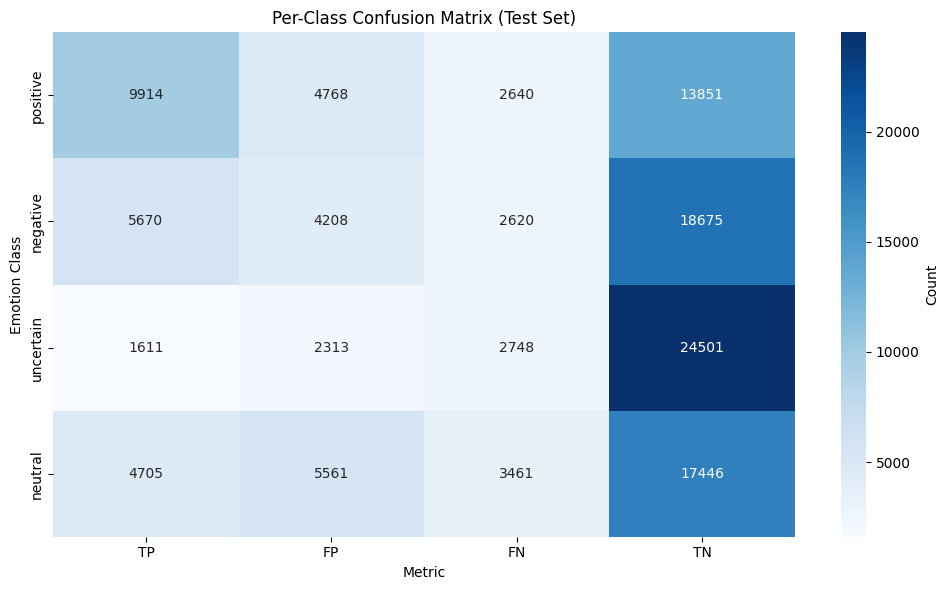

In [ ]:
# Calculate multilabel confusion matrix
cm = multilabel_confusion_matrix(y_test, y_test_pred)

# Extract TP, FP, FN, TN for each emotion
tp = cm[:, 1, 1]
fp = cm[:, 0, 1]
fn = cm[:, 1, 0]
tn = cm[:, 0, 0]

# Visualize
plt.figure(figsize=(10, 6))
confusion_data = np.array([tp, fp, fn, tn]).T
sns.heatmap(
    confusion_data,
    annot=True,
    fmt='d',
    xticklabels=["TP", "FP", "FN", "TN"],
    yticklabels=emotion_columns,
    cmap="Blues",
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Metric')
plt.ylabel('Emotion Class')
plt.title('Per-Class Confusion Matrix (Test Set)')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300)
plt.show()

## ROC Curves


AUC Scores (Test Set):
  positive: 0.836
  negative: 0.822
  uncertain: 0.742
  neutral: 0.724


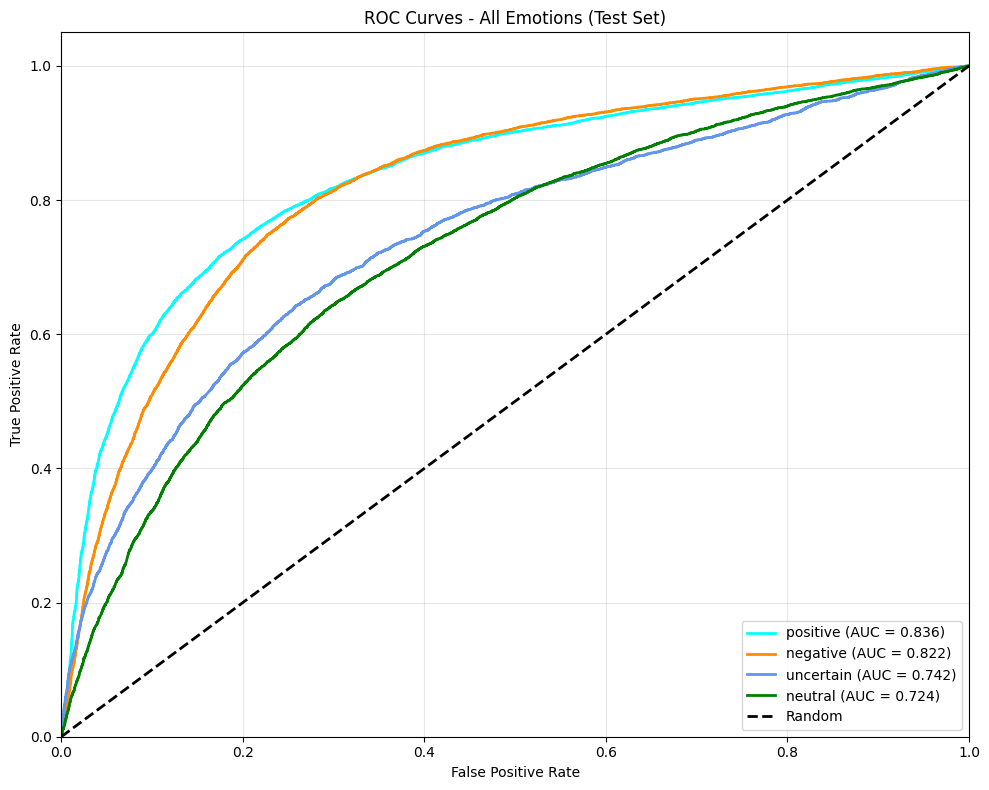

In [ ]:
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']

print("\nAUC Scores (Test Set):")
for i, (emotion, color) in enumerate(zip(emotion_columns, colors)):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{emotion} (AUC = {roc_auc:.3f})')
    print(f"  {emotion}: {roc_auc:.3f}")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Emotions (Test Set)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'roc_curves.png'), dpi=300)
plt.show()

## Test Predictions on Sample Sentences

In [ ]:
def predict_emotions(text, threshold=None):
    """
    Predict emotions for a single text.

    Args:
        text (str): Input text
        threshold (float): Probability threshold (uses best_thresh if None)

    Returns:
        dict: Detected emotions and probabilities
    """
    if threshold is None:
        threshold = best_thresh

    # Convert text to sequence and pad
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')

    # Predict probabilities
    probs = model.predict(padded, verbose=0)[0]

    # Get detected emotions
    detected = [emotion_columns[i] for i, prob in enumerate(probs) if prob > threshold]
    prob_dict = {emotion: float(probs[i]) for i, emotion in enumerate(emotion_columns)}

    return {
        'detected_emotions': detected,
        'probabilities': prob_dict
    }

In [ ]:
# Test on sample sentences
test_sentences = [
    "I'm so happy and excited about my new job!",
    "This is absolutely terrible, I can't believe this happened.",
    "I'm not really sure what to think about this situation.",
    "Just another day at work, nothing special.",
    "I love spending time with my family on weekends!",
    "I'm really angry and frustrated with how things turned out.",
    "What do you think about the new policy changes?",
    "Everything is fine, just going through the motions.",
    "This is amazing! Best day ever!",
    "I hate when people do that, it makes me so mad."
]

print("TESTING SAMPLE SENTENCES")

for text in test_sentences:
    result = predict_emotions(text)

    print(f"\nText: {text}")
    print(f"Detected: {', '.join(result['detected_emotions']) or 'none above threshold'}")

    # Show all probabilities with tick on highest only
    print("Probabilities:")
    max_emotion = max(result['probabilities'], key=result['probabilities'].get)
    for emotion in emotion_columns:
        prob = result['probabilities'][emotion]
        marker = "✓" if emotion == max_emotion else " "
        print(f"  {marker} {emotion}: {prob:.4f}")

TESTING SAMPLE SENTENCES

Text: I'm so happy and excited about my new job!
Detected: positive, uncertain
Probabilities:
  ✓ positive: 0.9947
    negative: 0.0144
    uncertain: 0.5136
    neutral: 0.0001

Text: This is absolutely terrible, I can't believe this happened.
Detected: negative
Probabilities:
    positive: 0.0167
  ✓ negative: 0.9465
    uncertain: 0.0123
    neutral: 0.0386

Text: I'm not really sure what to think about this situation.
Detected: uncertain
Probabilities:
    positive: 0.0056
    negative: 0.3349
  ✓ uncertain: 0.6455
    neutral: 0.1888

Text: Just another day at work, nothing special.
Detected: positive, neutral
Probabilities:
    positive: 0.4445
    negative: 0.0003
    uncertain: 0.0003
  ✓ neutral: 0.7707

Text: I love spending time with my family on weekends!
Detected: positive, neutral
Probabilities:
  ✓ positive: 0.9034
    negative: 0.0000
    uncertain: 0.0001
    neutral: 0.4021

Text: I'm really angry and frustrated with how things turned out.
De

In [12]:
import os
import joblib
from tensorflow.keras.models import load_model

# Define paths (as set in your notebook)
base_path = '/content/drive/MyDrive/Text_Emotion_Classifier'
save_dir = os.path.join(base_path, 'model/grouped_emotions_lstm')
model_path = os.path.join(save_dir, 'best_model_checkpoint.keras')
tokenizer_path = os.path.join(save_dir, "tokenizer.pkl")

# Load the resources
model = load_model(model_path)
tokenizer = joblib.load(tokenizer_path)

print("Model and Tokenizer loaded successfully.")

Model and Tokenizer loaded successfully.


## Precision & Recall Curve

975/975 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


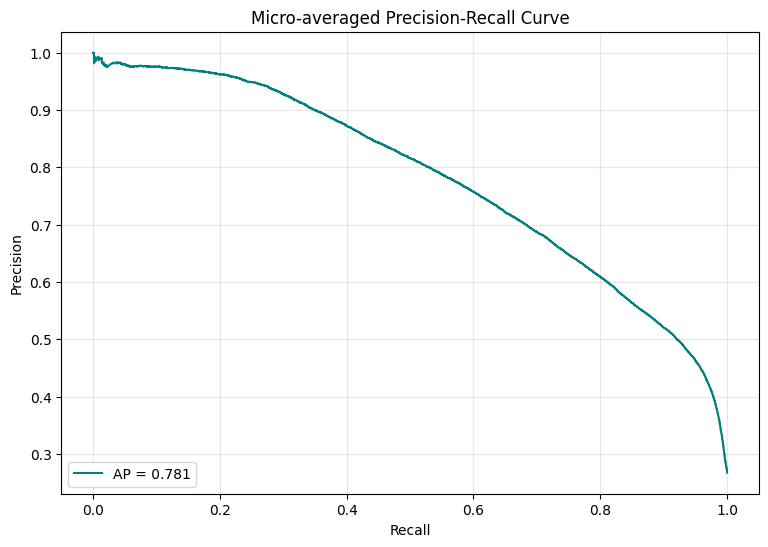

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

X_val_padded = pad_sequences(sequences_val, maxlen=MAX_LEN, padding='post')
y_pred_prob = model.predict(X_val_padded)

precision, recall, _ = precision_recall_curve(y_val.ravel(), y_pred_prob.ravel())
ap = average_precision_score(y_val.ravel(), y_pred_prob.ravel())

plt.figure(figsize=(9, 6))
plt.step(recall, precision, where='post', color='teal', label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-averaged Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()

## Word Cloud

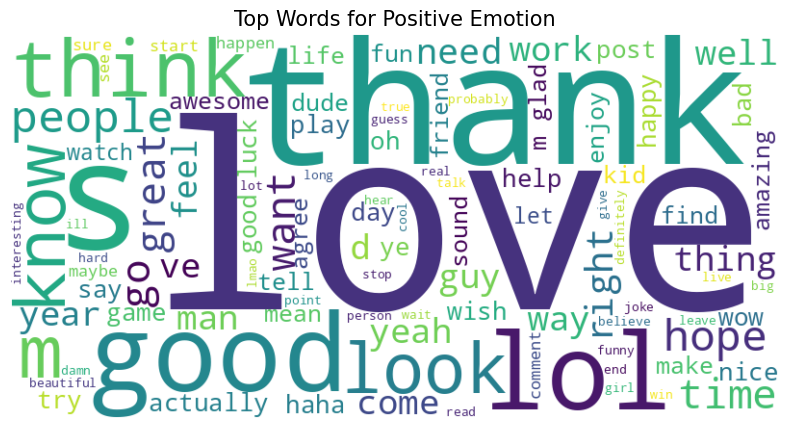

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_emotion_wordcloud(df, emotion_label):
    """
    Generates a word cloud for a specific emotion category.
    """
    # Filter text where the specific emotion is present
    subset = df[df[emotion_label] == 1]
    text = " ".join(subset['cleaned_text'].astype(str))

    # Create the WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top Words for {emotion_label.capitalize()} Emotion', fontsize=15)
    plt.axis('off')
    plt.show()

generate_emotion_wordcloud(df, 'positive')

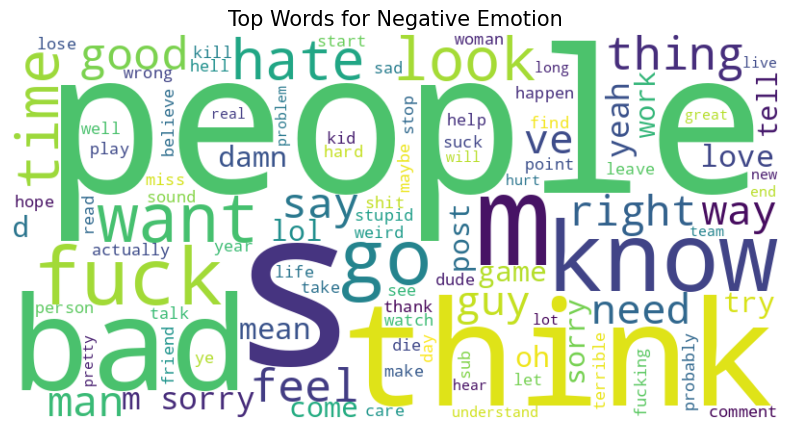

In [ ]:
generate_emotion_wordcloud(df, 'negative')

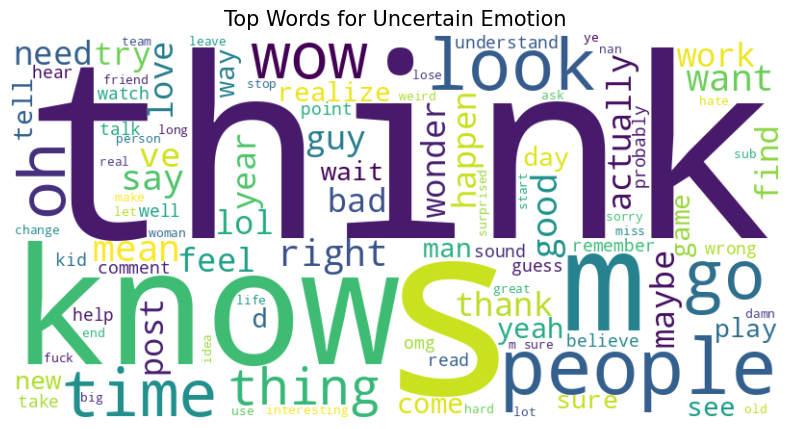

In [ ]:
generate_emotion_wordcloud(df, 'uncertain')

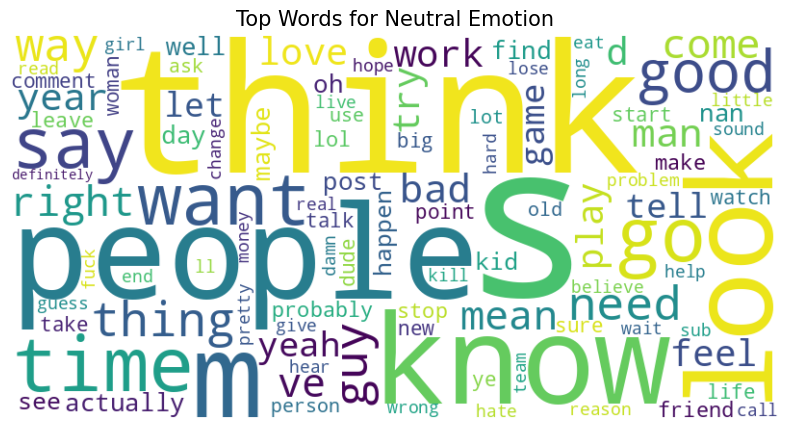

In [ ]:
generate_emotion_wordcloud(df, 'neutral')

## LIME Explanable

In [ ]:
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from tqdm import tqdm

In [ ]:
def lstm_predictor(texts):
    """
    Predictor function for LIME: Converts raw text to padded sequences
    and returns model predictions.
    """
    # Convert raw text to sequences using the loaded tokenizer
    sequences = tokenizer.texts_to_sequences(texts)
    # Pad sequences to match the model's expected input length (MAX_LEN=128)
    padded = pad_sequences(sequences, maxlen=128, padding='post', truncating='post')
    # Get model probabilities
    probs = model.predict(padded, verbose=0)
    return probs

# Initialize the explainer with your emotion labels
explainer = LimeTextExplainer(class_names=emotion_columns)

Analyzing 50 samples...


100%|██████████| 50/50 [01:12<00:00,  1.44s/it]
/tmp/ipython-input-1776912253.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-1776912253.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-1776912253.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, ax=axes[i], palette="viridis")
/tmp/ipython-input-1776912253.py:11: FutureWarning: 

Passing `palette` without assigning `hue` i

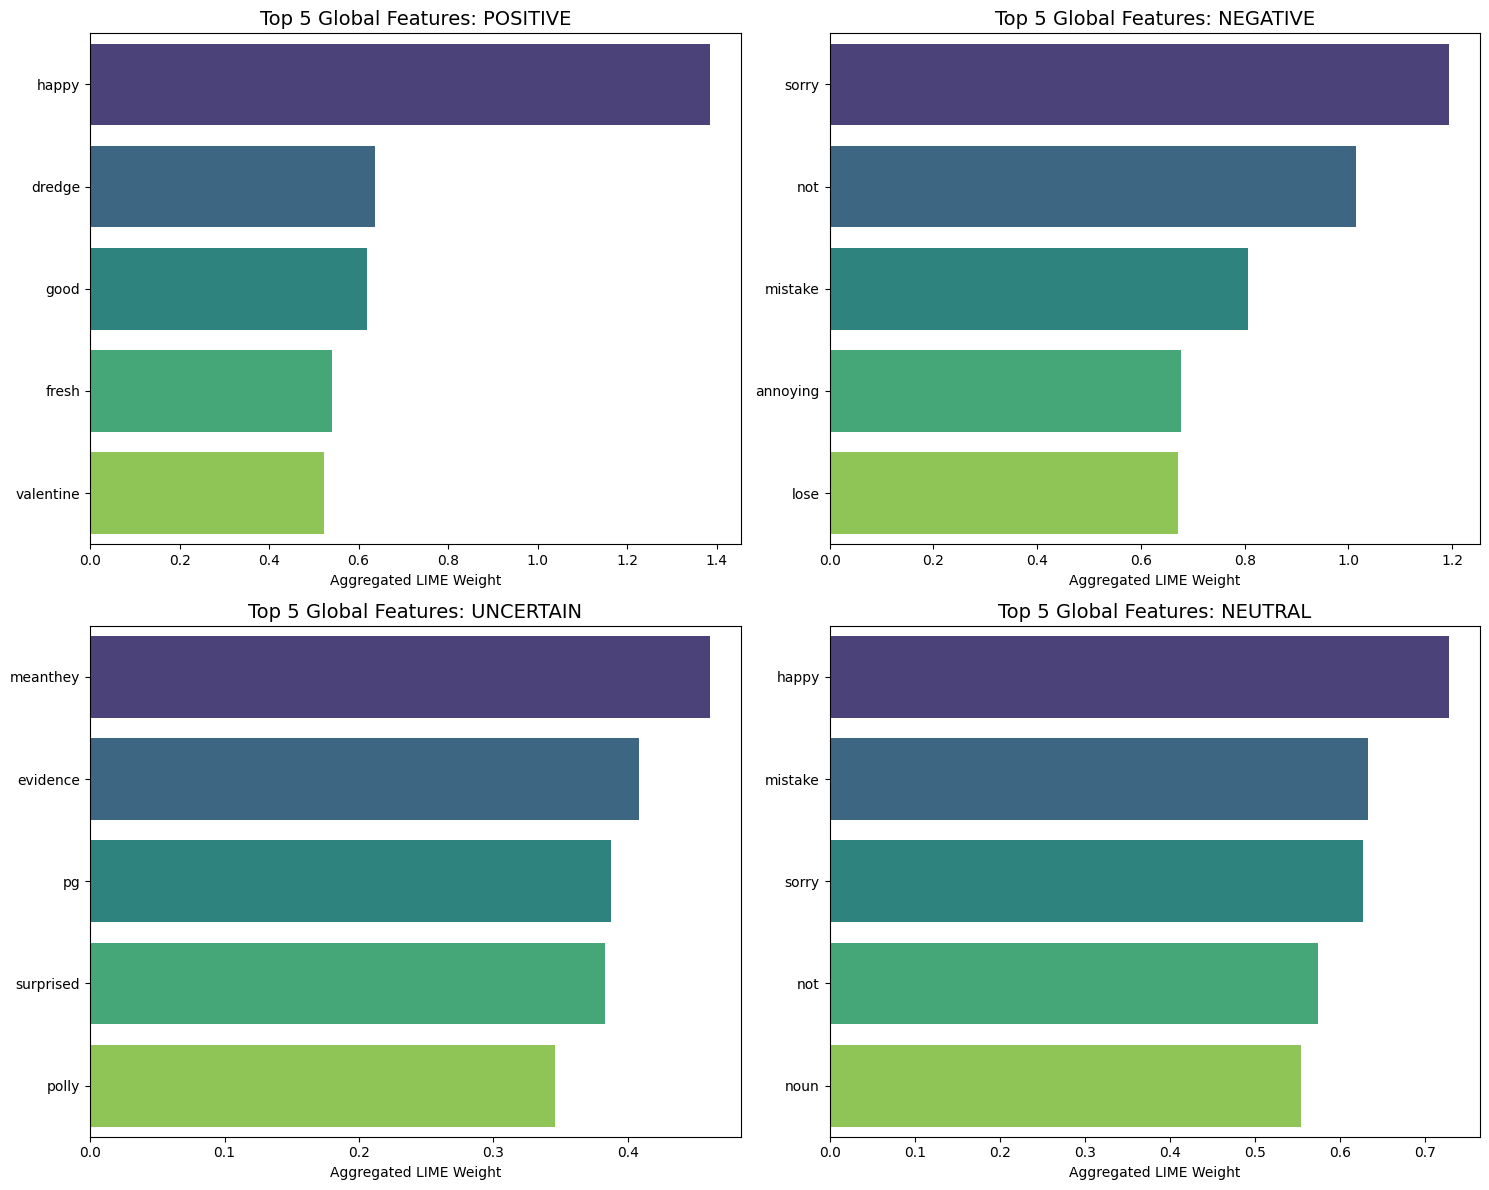

In [ ]:
def get_lstm_global_importance(dataframe, num_samples=50):
    global_weights = {i: defaultdict(float) for i in range(len(emotion_columns))}

    # Sample data for efficiency
    sample_df = dataframe.sample(n=min(num_samples, len(dataframe)), random_state=42)

    print(f"Analyzing {len(sample_df)} samples...")
    for text in tqdm(sample_df['cleaned_text']):
        exp = explainer.explain_instance(
            text,
            lstm_predictor,
            num_features=5,
            labels=range(len(emotion_columns))
        )

        for i in range(len(emotion_columns)):
            for word, weight in exp.as_list(label=i):
                global_weights[i][word] += abs(weight)

    return global_weights

# Run and plot using your existing plot_global_lime function
lstm_weights = get_lstm_global_importance(df, num_samples=50)
plot_global_lime(lstm_weights)